<a href="https://colab.research.google.com/github/pscabral/IFMA_Softex/blob/main/vgg16_1.00_160.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
import gdown

# Especifique o ID do arquivo e o nome do arquivo de saída
file_id = '1aX48j7lKyE0c66tMZEesOwNncFbyvu6X'
output = 'dataset.zip'

# Baixe o arquivo do Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
!unzip dataset.zip

In [2]:
import os

# Diretório raiz que você deseja verificar
diretorio_raiz = '/content/dataset_3'

# Inicialize uma variável para contar o número de imagens
num_imagens = 0

# Percorra recursivamente o diretório e seus subdiretórios
for pasta_raiz, pastas, arquivos in os.walk(diretorio_raiz):
    for arquivo in arquivos:
        if arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tif', '.tiff')):
            # Se o arquivo tem uma extensão de imagem, incremente o contador
            num_imagens += 1

print(f'O número total de imagens em {diretorio_raiz} e seus subdiretórios é: {num_imagens}')


O número total de imagens em /content/dataset_3 e seus subdiretórios é: 3825


In [ ]:
!pip install tensorflow-addons
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception, VGG16, InceptionV3, ResNet101
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import tensorflow as tf
import pandas as pd

In [6]:
train = Path('../content/dataset_3/train')
train_filepaths = list(train.glob(r'**/*.jpg'))

valid = Path('../content/dataset_3/validation')
valid_filepaths = list(valid.glob(r'**/*.jpg'))

test = Path('../content/dataset_3/test')
test_filepaths = list(test.glob(r'**/*.jpg'))

In [7]:
def process_img(filepath):

    labels = [str(filepath[i]).split("/")[-2]
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')

    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop = True)

    return df

In [8]:
train_df = process_img(train_filepaths)
valid_df = process_img(valid_filepaths)
test_df = process_img(test_filepaths)
train_df.head()

,FilePath,Label
0,../content/dataset_3/train/capsicum/Image_40.jpg,capsicum
1,../content/dataset_3/train/cucumber/Image_86.jpg,cucumber
2,../content/dataset_3/train/orange/Image_70.jpg,orange
3,../content/dataset_3/train/pineapple/Image_83.jpg,pineapple
4,../content/dataset_3/train/peas/Image_21.jpg,peas


In [9]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(set(train_df.Label))}\n')
print(f'Labels: {set(train_df.Label)}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: {'capsicum', 'pomegranate', 'ginger', 'raddish', 'cauliflower', 'sweetcorn', 'tomato', 'corn', 'spinach', 'cucumber', 'peas', 'lettuce', 'paprika', 'carrot', 'pear', 'bell pepper', 'sweetpotato', 'apple', 'mango', 'watermelon', 'lemon', 'garlic', 'beetroot', 'pineapple', 'kiwi', 'eggplant', 'grapes', 'cabbage', 'turnip', 'orange', 'soy beans', 'chilli pepper', 'banana', 'onion', 'potato', 'jalepeno'}


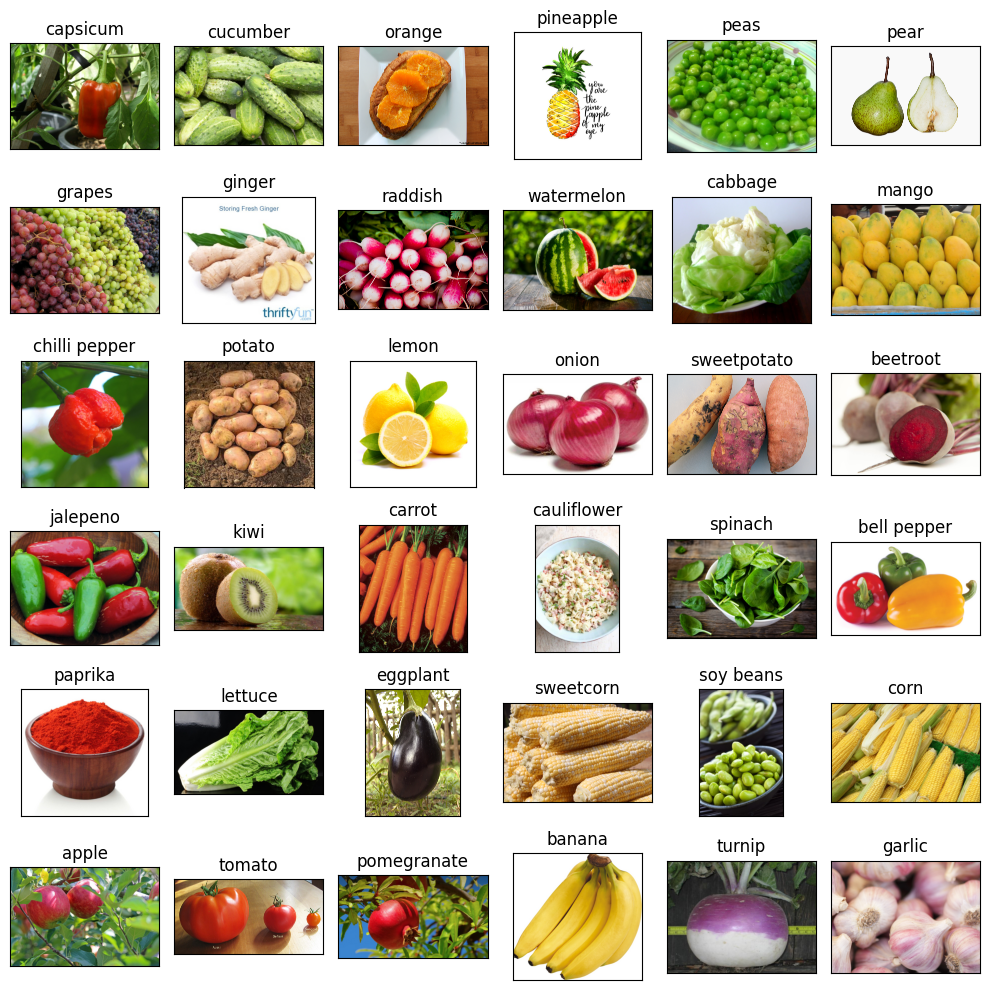

In [10]:
unique_labels = train_df.copy().drop_duplicates(subset=['Label']).reset_index()

fig, axes = plt.subplots(6, 6, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    if i < len(unique_labels):
        ax.imshow(plt.imread(unique_labels.FilePath[i]))
        ax.set_title(unique_labels.Label[i], fontsize=12)
    else:
        # If the index is out of range, you can handle it here (e.g., by leaving the subplot blank).
        ax.axis('off')  # Turn off the subplot

plt.tight_layout()
plt.show()

In [11]:
# Fetch and process the data
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
)
train_images = data_gen.flow_from_dataframe(
    dataframe = train_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valid_images = data_gen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = data_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='FilePath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2780 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.
Found 334 validated image filenames belonging to 36 classes.


In [12]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
)
base_model.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [13]:
inputs = base_model.input

x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    validation_data=valid_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 1703s 20s/step - loss: 2.3569 - accuracy: 0.4568 - val_loss: 0.6407 - val_accuracy: 0.8353
Epoch 2/5
87/87 [==============================] - 1672s 19s/step - loss: 0.7585 - accuracy: 0.7878 - val_loss: 0.3211 - val_accuracy: 0.9251
Epoch 3/5
87/87 [==============================] - 1668s 19s/step - loss: 0.4315 - accuracy: 0.8673 - val_loss: 0.2220 - val_accuracy: 0.9551
Epoch 4/5
87/87 [==============================] - 1680s 19s/step - loss: 0.2807 - accuracy: 0.9205 - val_loss: 0.2343 - val_accuracy: 0.9371
Epoch 5/5
87/87 [==============================] - 1691s 19s/step - loss: 0.1752 - accuracy: 0.9489 - val_loss: 0.1953 - val_accuracy: 0.9521


In [ ]:
#https://www.kaggle.com/code/ilyasavchenko/fruits-and-vegetables-transfer-learning

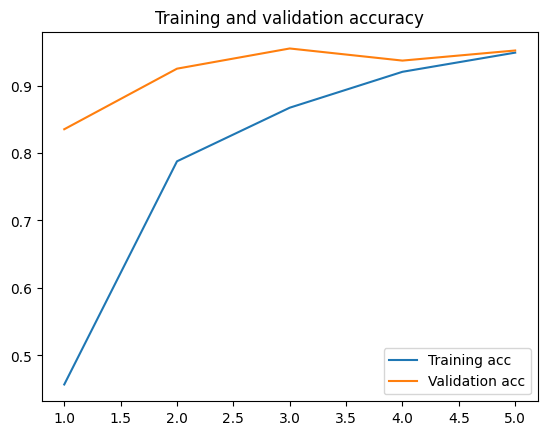

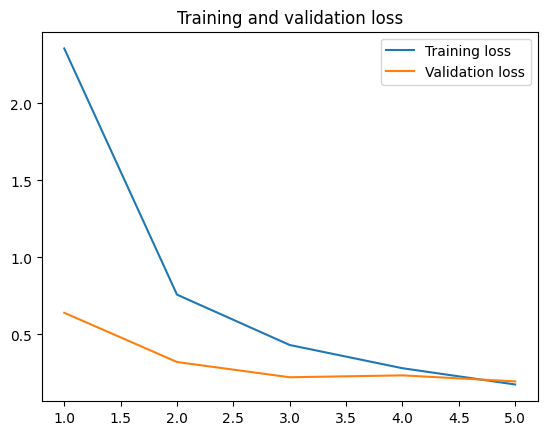

In [14]:
#Train accuracy and validation accuracy vs epoch graph

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [15]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)
pred

11/11 [==============================] - 183s 16s/step


array([20, 11, 11, 13, 28, 10, 17, 31, 23, 12,  0, 29, 18, 29, 31, 32,  2,
       35, 29, 16, 27, 30,  4, 13,  7, 31, 14, 26, 16,  6, 26, 11, 24, 18,
       10, 30,  6,  2, 10, 29,  7, 10, 25,  6, 23,  6, 22, 26, 33, 14, 24,
       16, 23, 22, 18,  7,  5, 26, 25,  0,  9, 19, 16, 14, 30, 22, 23,  4,
       10,  8, 32, 27, 11, 15, 23, 10, 11, 12, 28, 28, 19,  3, 15, 35, 21,
        3, 21, 11, 35, 34, 12,  9, 33,  2, 29, 34,  0, 27, 12,  8, 28,  4,
       29, 31,  9, 32, 22, 21, 12, 31, 26,  0, 31, 20, 30,  6, 21,  9,  3,
       35, 31, 35,  0, 24, 28,  2, 20, 24, 19, 15, 35, 27, 25, 12, 33,  5,
        4, 35,  4, 24, 10, 18, 33, 21, 15, 19, 13, 19, 32, 33,  4, 14, 17,
       22, 17, 22, 23, 21, 23, 22, 23,  7, 34, 16,  8, 19,  3, 17, 13, 31,
        2,  7, 34, 17,  8, 14, 31,  3,  8,  6, 32,  3, 26, 29, 20,  4, 13,
        7, 24, 12, 19, 33, 34,  0, 13, 17, 20,  2,  0,  9, 18,  3, 25, 18,
       18, 32,  4, 28, 15, 11, 18,  8,  8, 13,  3,  5, 30, 11,  5,  1,  5,
       22, 29, 34, 21, 24

In [16]:
labels = (train_images.class_indices)
labels

{'apple': 0,
 'banana': 1,
 'beetroot': 2,
 'bell pepper': 3,
 'cabbage': 4,
 'capsicum': 5,
 'carrot': 6,
 'cauliflower': 7,
 'chilli pepper': 8,
 'corn': 9,
 'cucumber': 10,
 'eggplant': 11,
 'garlic': 12,
 'ginger': 13,
 'grapes': 14,
 'jalepeno': 15,
 'kiwi': 16,
 'lemon': 17,
 'lettuce': 18,
 'mango': 19,
 'onion': 20,
 'orange': 21,
 'paprika': 22,
 'pear': 23,
 'peas': 24,
 'pineapple': 25,
 'pomegranate': 26,
 'potato': 27,
 'raddish': 28,
 'soy beans': 29,
 'spinach': 30,
 'sweetcorn': 31,
 'sweetpotato': 32,
 'tomato': 33,
 'turnip': 34,
 'watermelon': 35}

In [17]:
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]
y_test = [labels[k] for k in test_images.classes]
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 95.21%


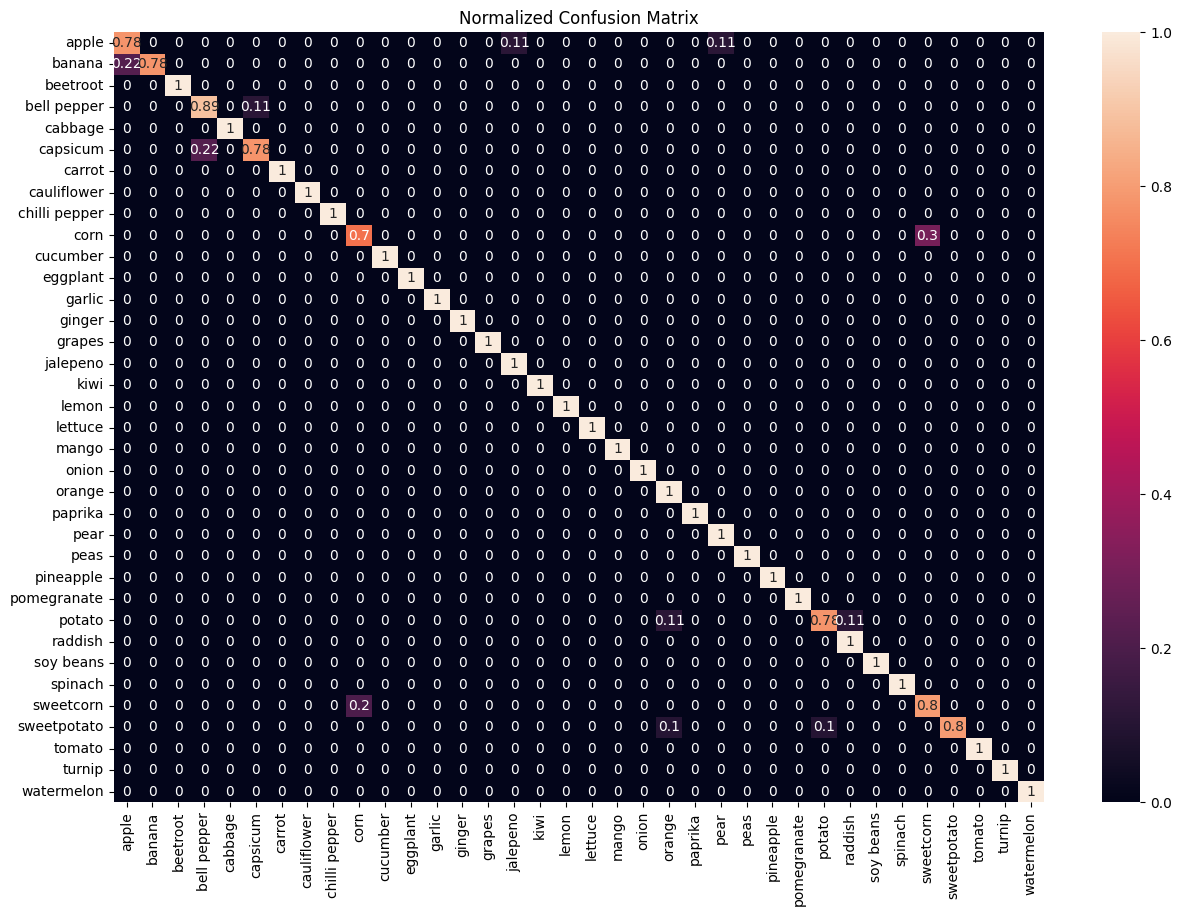

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix, annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test))
           )
plt.title('Normalized Confusion Matrix')
plt.show()